# GBT DCR "Decoding"

We use the term "decoding" to refer to the process by which the relevant FITS files associated with a given DCR scan are processed and merged together. You might also hear the term "filling" used instead.

There are three FITS files that contribute to "the DCR data":
1. `DCR`
2. `IF`
3. `Antenna`

These must be properly parsed, ordered, and joined in order for sensible queries to be performed on the result.

This document is based on commit `ba57ddacb649fa85ee8e08acfc0e962babf2812f`

## Step 1: Data Aquisition

In [60]:
import os

from astropy.io import fits

# TODO: Fix this path
fits_dir = "./AGBT02A_025_01:1000:Rcvr12_18"
dcr_hdul = fits.open(os.path.join(fits_dir, 'DCR', '2004_03_04_00:56:43.fits'))
if_hdul = fits.open(os.path.join(fits_dir, 'IF', '2004_03_04_00:56:43.fits'))
ant_hdul = fits.open(os.path.join(fits_dir, 'Antenna', '2004_03_04_00:56:43.fits'))

### A brief tangent: the nature of "phase"

Phase can be thought of as a _state_, and is composed of two other states: that of the calibration diode and that of the signal/reference beam selection

| `SIGREF` | `CAL` |      Phase key       | Phase index |
|----------|-------|----------------------|-------------|
|        0 |     0 | `Signal / No Cal`    |           0 |
|        0 |     1 | `Signal / Cal`       |           1 |
|        1 |     0 | `Reference / No Cal` |           2 |
|        1 |     1 | `Reference / Cal`    |           3 |

## Step 2: Table Initialization

We will now convert our `HDUList` objects to `Table` objects so they can be more easily manipulated

### Step 2.1: DCR State Table Conversion

In [2]:
from astropy.table import Table

dcr_state_table = Table.read(dcr_hdul[dcr_hdul.index_of('STATE')])
dcr_state_table

BLANKTIM,PHASETIM,SIGREF,CAL,SWSIG1,SWSIG2,SWSIG3,SWSIG4,SWSIG5
s,s,,,,,,,
float64,float64,uint8,uint8,uint8,uint8,uint8,uint8,uint8
0.002,0.05,0,0,0,0,0,0,1
0.002,0.05,0,1,0,0,0,0,0
0.002,0.05,1,0,0,0,0,0,1
0.002,0.05,1,1,0,0,0,0,0


Now let's trim off the columns we don't need, and then add some "helper" columns that more concisely describe the phase represented (since this is how we'll be thinking about the data) anyway

In [64]:
import numpy as np
from astropy.table import Column

# Trim off unneeded columns
dcr_state_table = dcr_state_table['SIGREF', 'CAL']

# Construct the "verbose" phases
phases_verbose = ['{} / {}'.format('Signal' if not sigref else 'Reference', 'Cal' if cal else 'No Cal')
                  for sigref, cal in dcr_state_table]
# Create the two new columns and add them to the state table
dcr_state_table.add_columns([
    Column(
        name='PHASE_ID',
        data=np.arange(len(phases_verbose))
    ),
    Column(
        name='PHASE',
        data=phases_verbose
    )
])
dcr_state_table

SIGREF,CAL,PHASE_ID,PHASE
uint8,uint8,int64,str18
0,0,0,Signal / No Cal
0,1,1,Signal / Cal
1,0,2,Reference / No Cal
1,1,3,Reference / Cal


### Step 2.2: DCR Data Table Initialization

In [36]:
dcr_data_table = Table.read(dcr_hdul[dcr_hdul.index_of('DATA')])
dcr_data_table

IFFLAG,SUBSCAN,TIMETAG,"DATA [2,4]"
CODE,CODE,DMJD,COUNTS
int16,int32,float64,int32
0,1,53068.039386580334,188315 .. 211099
0,2,53068.03938889521,188380 .. 209369
0,3,53068.03939121,188290 .. 206591
0,4,53068.039393524814,188440 .. 202913
0,5,53068.03939584034,188634 .. 201291
0,6,53068.03939815451,188737 .. 197217
0,7,53068.03940046931,188785 .. 194893
0,8,53068.03940278415,188706 .. 194166


### Step 2.3: IF IF Table Initialization

Initialize the table:

In [37]:
if_if_table = Table.read(if_hdul[if_hdul.index_of('IF')])
if_if_table

BACKEND,BANK,PORT,RECEIVER,FEED,SRFEED1,SRFEED2,RECEPTOR,LO_CIRCUIT,LO_COMPONENT,SIDEBAND,POLARIZE,CENTER_IF,CENTER_SKY,BANDWDTH,HIGH_CAL,TEST_TONE_IF,TEST_TONE_SKY,TEST_TONE_CIRCUIT,TEST_TONE_COMPONENT,SFF_MULTIPLIER,SFF_SIDEBAND,SFF_OFFSET,TRANSFORM_COUNT,TRANSFORMS
none,none,none,none,none,none,none,none,none,none,none,none,Hz,Hz,Hz,none,Hz,Hz,none,none,none,none,none,none,none
str32,str2,int32,str32,int32,int32,int32,str8,str32,str32,str2,str2,float32,float32,float32,int32,float32,float32,str32,str32,float64,float64,float64,int32,str4096
DCR,A,2,Rcvr12_18,1,1,2,L1,LO1A,synthesizer,U,L,2752000000.0,14098000000.0,3004000000.0,0,nan,nan,,,1.0,1.0,0.0,12,"feed(Rcvr12_18:L1): 11800 to 15600, left_circular polarization; tone(Rcvr12_18:C1L): 0 x0; filter(Rcvr12_18:FL1L): 11800 to 15600; mixer(Rcvr12_18:MX1L): LO: 11346 (x1) from LO1A:synthesizer, IFo = IFi - 11346; filter(Rcvr12_18:FL4L): 1250 to 4750; (Rcvr12_18:J5): ; (IFRouter:J10): ; (IFRouter:J66): ; (OpticalDriver2:J1): ; attenuator(OpticalDriver2:attenuator): ; (OpticalDriver2:J4): ; (DCR:J2): ;"
DCR,A,4,Rcvr12_18,1,1,2,R1,LO1A,synthesizer,U,R,2752000000.0,14098000000.0,3004000000.0,0,nan,nan,,,1.0,1.0,0.0,12,"feed(Rcvr12_18:R1): 11800 to 15600, right_circular polarization; tone(Rcvr12_18:C1R): 0 x0; filter(Rcvr12_18:FL1R): 11800 to 15600; mixer(Rcvr12_18:MX1R): LO: 11346 (x1) from LO1A:synthesizer, IFo = IFi - 11346; filter(Rcvr12_18:FL4R): 1250 to 4750; (Rcvr12_18:J3): ; (IFRouter:J26): ; (IFRouter:J68): ; (OpticalDriver4:J1): ; attenuator(OpticalDriver4:attenuator): ; (OpticalDriver4:J4): ; (DCR:J4): ;"
Spectrometer,A,1,Rcvr12_18,1,1,2,L1,LO1A,synthesizer,U,L,900000000.0,13457000000.0,200000000.0,0,nan,nan,,,1.0,1.0,1211000000.0,24,"feed(Rcvr12_18:L1): 11800 to 15600, left_circular polarization; tone(Rcvr12_18:C1L): 0 x0; filter(Rcvr12_18:FL1L): 11800 to 15600; mixer(Rcvr12_18:MX1L): LO: 11346 (x1) from LO1A:synthesizer, IFo = IFi - 11346; filter(Rcvr12_18:FL4L): 1250 to 4750; (Rcvr12_18:J5): ; (IFRouter:J10): ; (IFRouter:J66): ; (OpticalDriver2:J1): ; attenuator(OpticalDriver2:attenuator): ; (OpticalDriver2:J2): ; (OpticalReceiver2:J1): ; (OpticalReceiver2:J2): ; (ConverterModule1:J2): ; mixer(ConverterModule1:MX2): LO: 11711 (x1) from LO2_G1:synthesizer, IFo = 11711 - IFi; filter(ConverterModule1:FL1): 8500 to 10350; mixer(ConverterModule1:MX3): LO: 10500 (x1) from LO3Distribution1:synthesizer, IFo = 10500 - IFi; filter(ConverterModule1:FL2): 0 to 2200; attenuator(ConverterModule1:AT1): ; (ConverterModule1:J3): ; (SamplerFilter1:J1): ; filter(SamplerFilter1:FL2): 800 to 1000; (SamplerFilter1:J5): ; (Spectrometer:J1): ;"
Spectrometer,A,2,Rcvr12_18,1,1,2,R1,LO1A,synthesizer,U,R,900000000.0,13457000000.0,200000000.0,0,nan,nan,,,1.0,1.0,1211000000.0,24,"feed(Rcvr12_18:R1): 11800 to 15600, right_circular polarization; tone(Rcvr12_18:C1R): 0 x0; filter(Rcvr12_18:FL1R): 11800 to 15600; mixer(Rcvr12_18:MX1R): LO: 11346 (x1) from LO1A:synthesizer, IFo = IFi - 11346; filter(Rcvr12_18:FL4R): 1250 to 4750; (Rcvr12_18:J3): ; (IFRouter:J26): ; (IFRouter:J68): ; (OpticalDriver4:J1): ; attenuator(OpticalDriver4:attenuator): ; (OpticalDriver4:J2): ; (OpticalReceiver4:J1): ; (OpticalReceiver4:J2): ; (ConverterModule5:J2): ; mixer(ConverterModule5:MX2): LO: 11711 (x1) from LO2_G1:synthesizer, IFo = 11711 - IFi; filter(ConverterModule5:FL1): 8500 to 10350; mixer(ConverterModule5:MX3): LO: 10500 (x1) from LO3Distribution1:synthesizer, IFo = 10500 - IFi; filter(ConverterModule5:FL2): 0 to 2200; attenuator(ConverterModule5:AT1): ; (ConverterModule5:J3): ; (SamplerFilter5:J1): ; filter(SamplerFilter5:FL2): 800 to 1000; (SamplerFilter5:J5): ; (Spectrometer:J2): ;"
Spectrometer,B,3,Rcvr12_18,1,1,2,L1,LO1A,synthesizer,U,L,900000000.0,13879000000.0,200000000.0,0,nan,nan,,,1.0,1.0,1633000000.0,24,"feed(Rcvr12_18:L1): 11800 to 15600, left_circular polarization; tone(Rcvr12_18:C1L): 0 x0; filter(Rcvr12_18:FL1L): 11800 to 15600; mixer(Rcvr12_18:MX1L): LO: 11346 (x1) from LO1A:synthesizer, IFo = IFi 

Throw out non-DCR rows:

In [38]:
backend_mask = (np.char.rstrip(if_if_table['BACKEND']) == 'DCR')
if_if_table = if_if_table[backend_mask]
if_if_table

BACKEND,BANK,PORT,RECEIVER,FEED,SRFEED1,SRFEED2,RECEPTOR,LO_CIRCUIT,LO_COMPONENT,SIDEBAND,POLARIZE,CENTER_IF,CENTER_SKY,BANDWDTH,HIGH_CAL,TEST_TONE_IF,TEST_TONE_SKY,TEST_TONE_CIRCUIT,TEST_TONE_COMPONENT,SFF_MULTIPLIER,SFF_SIDEBAND,SFF_OFFSET,TRANSFORM_COUNT,TRANSFORMS
none,none,none,none,none,none,none,none,none,none,none,none,Hz,Hz,Hz,none,Hz,Hz,none,none,none,none,none,none,none
str32,str2,int32,str32,int32,int32,int32,str8,str32,str32,str2,str2,float32,float32,float32,int32,float32,float32,str32,str32,float64,float64,float64,int32,str4096
DCR,A,2,Rcvr12_18,1,1,2,L1,LO1A,synthesizer,U,L,2752000000.0,14098000000.0,3004000000.0,0,nan,nan,,,1.0,1.0,0.0,12,"feed(Rcvr12_18:L1): 11800 to 15600, left_circular polarization; tone(Rcvr12_18:C1L): 0 x0; filter(Rcvr12_18:FL1L): 11800 to 15600; mixer(Rcvr12_18:MX1L): LO: 11346 (x1) from LO1A:synthesizer, IFo = IFi - 11346; filter(Rcvr12_18:FL4L): 1250 to 4750; (Rcvr12_18:J5): ; (IFRouter:J10): ; (IFRouter:J66): ; (OpticalDriver2:J1): ; attenuator(OpticalDriver2:attenuator): ; (OpticalDriver2:J4): ; (DCR:J2): ;"
DCR,A,4,Rcvr12_18,1,1,2,R1,LO1A,synthesizer,U,R,2752000000.0,14098000000.0,3004000000.0,0,nan,nan,,,1.0,1.0,0.0,12,"feed(Rcvr12_18:R1): 11800 to 15600, right_circular polarization; tone(Rcvr12_18:C1R): 0 x0; filter(Rcvr12_18:FL1R): 11800 to 15600; mixer(Rcvr12_18:MX1R): LO: 11346 (x1) from LO1A:synthesizer, IFo = IFi - 11346; filter(Rcvr12_18:FL4R): 1250 to 4750; (Rcvr12_18:J3): ; (IFRouter:J26): ; (IFRouter:J68): ; (OpticalDriver4:J1): ; attenuator(OpticalDriver4:attenuator): ; (OpticalDriver4:J4): ; (DCR:J4): ;"


Trim off the columns that we don't need:

In [39]:
if_if_table = if_if_table['FEED', 'RECEPTOR', 'POLARIZE', 'CENTER_SKY', 'BANDWDTH', 'PORT', 'HIGH_CAL']
if_if_table

FEED,RECEPTOR,POLARIZE,CENTER_SKY,BANDWDTH,PORT,HIGH_CAL
none,none,none,Hz,Hz,none,none
int32,str8,str2,float32,float32,int32,int32
1,L1,L,14098000000.0,3004000000.0,2,0
1,R1,R,14098000000.0,3004000000.0,4,0


Strip the whitespace from our `str` columns:

In [40]:
# Uh oh, looks like the str columns are padded! Let's fix that
if_if_table['RECEPTOR'] = np.char.rstrip(if_if_table['RECEPTOR'])
if_if_table['POLARIZE'] = np.char.rstrip(if_if_table['POLARIZE'])
if_if_table

FEED,RECEPTOR,POLARIZE,CENTER_SKY,BANDWDTH,PORT,HIGH_CAL
none,,,Hz,Hz,none,none
int32,str8,str2,float32,float32,int32,int32
1,L1,L,14098000000.0,3004000000.0,2,0
1,R1,R,14098000000.0,3004000000.0,4,0


## Step 3: Joining the Tables

Okay, so we now have all of our tables set up! But for what purpose?

We now need to map each physical attribute (beam/port/etc.) to every permutation of phase. This means that, in this simple case, we will end up with `numPols` * `numPhases` (more complicated cases will require more terms). So, we determine that we need to have 8 total rows:

In [41]:
len(if_if_table) * len(dcr_state_table)

8

So, we need to "inflate" our tables using `vstack`:

In [42]:
from astropy.table import vstack

# Inflate IF table to reach 8 total rows:
stacked_if_table = vstack([if_if_table] * len(dcr_state_table))
# We must sort here so that we can properly join with the state table later -- we need one port on top of the other,
# not mixed together!
stacked_if_table.sort('PORT')
stacked_if_table

FEED,RECEPTOR,POLARIZE,CENTER_SKY,BANDWDTH,PORT,HIGH_CAL
none,,,Hz,Hz,none,none
int32,str8,str2,float32,float32,int32,int32
1,L1,L,14098000000.0,3004000000.0,2,0
1,L1,L,14098000000.0,3004000000.0,2,0
1,L1,L,14098000000.0,3004000000.0,2,0
1,L1,L,14098000000.0,3004000000.0,2,0
1,R1,R,14098000000.0,3004000000.0,4,0
1,R1,R,14098000000.0,3004000000.0,4,0
1,R1,R,14098000000.0,3004000000.0,4,0
1,R1,R,14098000000.0,3004000000.0,4,0


In [43]:
# Inflate state table to reach 8 total rows
stacked_state_table = vstack([dcr_state_table] * len(if_if_table))
stacked_state_table

SIGREF,CAL,PHASE_ID,PHASE
uint8,uint8,int64,str18
0,0,0,Signal / No Cal
0,1,1,Signal / Cal
1,0,2,Reference / No Cal
1,1,3,Reference / Cal
0,0,0,Signal / No Cal
0,1,1,Signal / Cal
1,0,2,Reference / No Cal
1,1,3,Reference / Cal


Great, now we have two tables of compatible shapes! We just need to stick them together:

In [44]:
# Ignore the warnings here; don't care in this simple example
import warnings
from astropy.utils.exceptions import AstropyWarning
warnings.simplefilter('ignore', AstropyWarning)

from astropy.table import hstack

dcr_table = hstack([stacked_if_table, stacked_state_table])
dcr_table

FEED,RECEPTOR,POLARIZE,CENTER_SKY,BANDWDTH,PORT,HIGH_CAL,SIGREF,CAL,PHASE_ID,PHASE
none,,,Hz,Hz,none,none,,,,
int32,str8,str2,float32,float32,int32,int32,uint8,uint8,int64,str18
1,L1,L,14098000000.0,3004000000.0,2,0,0,0,0,Signal / No Cal
1,L1,L,14098000000.0,3004000000.0,2,0,0,1,1,Signal / Cal
1,L1,L,14098000000.0,3004000000.0,2,0,1,0,2,Reference / No Cal
1,L1,L,14098000000.0,3004000000.0,2,0,1,1,3,Reference / Cal
1,R1,R,14098000000.0,3004000000.0,4,0,0,0,0,Signal / No Cal
1,R1,R,14098000000.0,3004000000.0,4,0,0,1,1,Signal / Cal
1,R1,R,14098000000.0,3004000000.0,4,0,1,0,2,Reference / No Cal
1,R1,R,14098000000.0,3004000000.0,4,0,1,1,3,Reference / Cal


## Data Selection

Now, let's take a quick detour to discuss how the data selection is going to work. `DCR.DATA.DATA` is time-domain data (i.e. per-integration) of the shape `(integration, port, phase)`:

In [45]:
dcr_data_table['DATA'].shape

(149, 2, 4)

We need to slice this out into the physical domain -- that is, get all of the data from all integrations that was taken for each unique set of physical attributes (port and phase). Let's take the first port (2) and the first phase (0, 0) as an example:

In [46]:
data = dcr_data_table['DATA']
# All data taken in the first integration
data[0]

array([[188315, 206737, 188401, 208401],
       [175363, 188055, 199285, 211099]], dtype=int32)

In [47]:
# All data taken via the first port in the first integration
data[0][0]

array([188315, 206737, 188401, 208401], dtype=int32)

In [48]:
# Phase "Signal / No Cal" datum taken via the first port in the first integration
data[0][0][0]

188315

#### NumPy Data Selection

But, how do we select data from this port/phase over _all_ integrations?

In [49]:
# All data taken via the first port
data[:, 0]

188315 .. 208401
188380 .. 206708
188290 .. 203304
188440 .. 199489
188634 .. 197584
188737 .. 193076
188785 .. 190518
188706 .. 189781
188497 .. 189557
188516 .. 189640
188416 .. 189543


In [50]:
# All data with phase phase "Signal / No Cal" taken via the first port
data[:, 0, 0]

188315
188380
188290
188440
188634
188737
188785
188706
188497
188516
188416


## Step 4: Map the Data

Add an empty DATA column as a placeholder:

In [51]:
dcr_table.add_column(
    Column(
        name='DATA',
        dtype=dcr_data_table['DATA'].dtype,
        shape=dcr_data_table['DATA'].shape[0],
        length=len(dcr_table)
    )
)
dcr_table

FEED,RECEPTOR,POLARIZE,CENTER_SKY,BANDWDTH,PORT,HIGH_CAL,SIGREF,CAL,PHASE_ID,PHASE,DATA [149]
none,,,Hz,Hz,none,none,,,,,
int32,str8,str2,float32,float32,int32,int32,uint8,uint8,int64,str18,int32
1,L1,L,14098000000.0,3004000000.0,2,0,0,0,0,Signal / No Cal,0 .. 0
1,L1,L,14098000000.0,3004000000.0,2,0,0,1,1,Signal / Cal,0 .. 0
1,L1,L,14098000000.0,3004000000.0,2,0,1,0,2,Reference / No Cal,0 .. 0
1,L1,L,14098000000.0,3004000000.0,2,0,1,1,3,Reference / Cal,0 .. 0
1,R1,R,14098000000.0,3004000000.0,4,0,0,0,0,Signal / No Cal,0 .. 0
1,R1,R,14098000000.0,3004000000.0,4,0,0,1,1,Signal / Cal,0 .. 0
1,R1,R,14098000000.0,3004000000.0,4,0,1,0,2,Reference / No Cal,0 .. 0
1,R1,R,14098000000.0,3004000000.0,4,0,1,1,3,Reference / Cal,0 .. 0


Now, perform the actual selection of the data:

In [58]:
for ri, row in enumerate(dcr_table):
    phase_id = row['PHASE_ID']
    # Determine the index of the current port
    # TODO: Big performance gain if port_index were tracked within dcr_table
    port_index = np.where(np.unique(dcr_table['PORT']) == row['PORT'])[0][0]
    # Select all data associated with phase and port
    dcr_table['DATA'][ri] = dcr_data_table['DATA'][::, port_index, phase_id]
    
dcr_table

FEED,RECEPTOR,POLARIZE,CENTER_SKY,BANDWDTH,PORT,HIGH_CAL,SIGREF,CAL,PHASE_ID,PHASE,DATA [149]
none,,,Hz,Hz,none,none,,,,,
int32,str8,str2,float32,float32,int32,int32,uint8,uint8,int64,str18,int32
1,L1,L,14098000000.0,3004000000.0,2,0,0,0,0,Signal / No Cal,188315 .. 186796
1,L1,L,14098000000.0,3004000000.0,2,0,0,1,1,Signal / Cal,206737 .. 205060
1,L1,L,14098000000.0,3004000000.0,2,0,1,0,2,Reference / No Cal,188401 .. 167530
1,L1,L,14098000000.0,3004000000.0,2,0,1,1,3,Reference / Cal,208401 .. 187340
1,R1,R,14098000000.0,3004000000.0,4,0,0,0,0,Signal / No Cal,175363 .. 174353
1,R1,R,14098000000.0,3004000000.0,4,0,0,1,1,Signal / Cal,188055 .. 186965
1,R1,R,14098000000.0,3004000000.0,4,0,1,0,2,Reference / No Cal,199285 .. 180831
1,R1,R,14098000000.0,3004000000.0,4,0,1,1,3,Reference / Cal,211099 .. 192353


Okay... but what can we *do* with this?

Let's try out something similar to what you might do in GFM: plot the "Signal / No Cal" phase for both polarizations

<IPython.core.display.Javascript object>


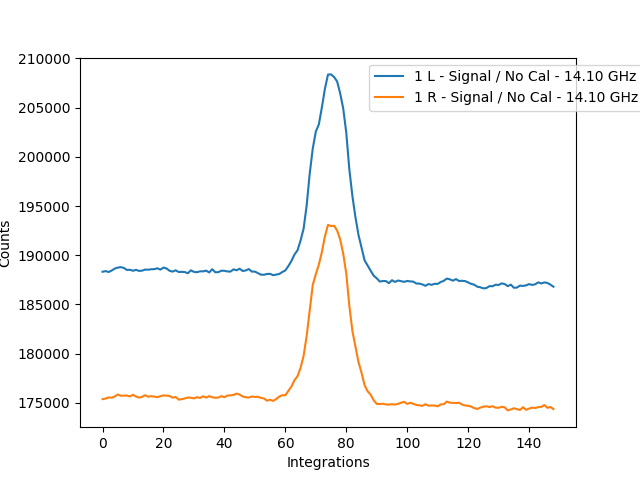

FEED,RECEPTOR,POLARIZE,CENTER_SKY,BANDWDTH,PORT,HIGH_CAL,SIGREF,CAL,PHASE_ID,PHASE,DATA [149]
none,,,Hz,Hz,none,none,,,,,
int32,str8,str2,float32,float32,int32,int32,uint8,uint8,int64,str18,int32
1,L1,L,14098000000.0,3004000000.0,2,0,0,0,0,Signal / No Cal,188315 .. 186796
1,R1,R,14098000000.0,3004000000.0,4,0,0,0,0,Signal / No Cal,175363 .. 174353


In [65]:
%matplotlib notebook

from astropy import units
import matplotlib.pyplot as plt

# Mask out everything but 'Signal / No Cal' data
row_mask = dcr_table['PHASE'] == 'Signal / No Cal'
sig_no_cal = dcr_table[row_mask]
data = sig_no_cal['DATA']

# Transpose data here so that each row results in a new axis (instead of each column, which makes little sense)
plt.plot(data.T)
# Convert our center freq to GHz
center_freq = dcr_table['CENTER_SKY'].to('GHz')[0]
plt.xlabel('Integrations')
plt.ylabel('Counts')
plt.legend(['1 L - Signal / No Cal - {:0.2f}'.format(center_freq),
            '1 R - Signal / No Cal - {:0.2f}'.format(center_freq)],
          bbox_to_anchor=(1.15, 1.0))
# Display the plot
plt.show()
# Display the table being plotted
sig_no_cal